## Willow Flycatcher Migration

<img src="willow-flycatcher.png" alt="Willow Flycatcher" width="720" height="550" longdesc="https://macaulaylibrary.org/asset/451259001" /> 

#### Species Description
Willow Flycatchers (*Empidonax traillii*) specialize in areas with willows and other shrubs [near running and still water](https://www.audubon.org/field-guide/bird/willow-flycatcher). They are about 6 inches in length with brown, gray, and white plumage, a rounded wing, and a square-tipped tail. Calls are in the form of a chirp, buzz, or trill and match an undulating pattern. Nests are placed 4-15 feet above water or damp ground and constructed as an open cup of grass, bark, and plant fibers. The species migrates long distances, breeding in the U.S. and Canada and wintering in Mexico, Central America, and northern South America. They are common in most locations in their range despite a [25% decline](https://www.allaboutbirds.org/guide/Willow_Flycatcher/lifehistory) in population between 1966 to 2019. The loss of wet marshes, wet meadows, and riparian vegetation has contributed to [declining species abundance](https://www.fs.usda.gov/detail/tahoe/landmanagement/resourcemanagement/?cid=stelprdb5357314#:~:text=The%20scientific%20name%20for%20willow,t). According to the Bird Genoscape Project, there are seven geneticially [distinct populations](https://www.birdgenoscape.org/willow-flycatcher/) of Willow Flycatcher in North America: the Pacific Northwest, Kern, California, southern California, White Mountain, Arizona, Interior West, Southwest, and Eastern. However, there are only four recognized subspecies: *E. t. brewsteri*, *E. t. adastus*, *E. t. extimus*, and *E. t. traillii*. 

In my home state of California, there are three [endangered subspecies](https://www.fs.usda.gov/detail/tahoe/landmanagement/resourcemanagement/?cid=stelprdb5357314#:~:text=The%20scientific%20name%20for%20willow,t): Southwestern Willow Flycatcher in central and southern California (Federal and State), Little Willow Flycatcher in high elevation Sierra Nevada (State), and Great Basin Willow Flycatcher in desert riparian area (State). Researchers have found that the Southwestern Willow Flycatcher has a higher prevalence of gene variants today compared to 100 years ago that are associated with [adapting to wet and humid conditions](https://www.allaboutbirds.org/news/endangered-willow-flycatchers-in-san-diego-are-adapting-to-climate-change/). This difference is likely due to interbreeding with species in the Southwest and Pacific Northwest, producing an evolutionary response to climate change. Adaptations like these are why it is vital to preserve the interconnectivity of species populations through the protection of habitat and landscape mobility.

#### Data Description

The [GBIF Occurrence dataset](https://doi.org/10.15468/dl.jqrwjf) was retrived from the Global Biodiversity Information Facility Occurrence Store and is scoped to the year of interest (2023) and species under observation. There are 110,725 species occurrences total which are indicated by geographic coordinates spanning across five aggregated datasets. 

The [RESOLVE Ecoregions dataset](https://developers.google.com/earth-engine/datasets/catalog/RESOLVE_ECOREGIONS_2017) (2017) depicts Earth's 846 terrestrial ecoregions and was obtained as a shapefile. Ecoregions represent boundaries formed by biotic and abiotic conditions: geology, landforms, soils, vegetation, land use, wildlife, climate, and hydrology.

#### Data Citations

Global Biodiversity Information Facility. (2024). *GBIF Occurrence Download* [Data set]. https://doi.org/10.15468/dl.jqrwjf

RESOLVE. (2017). *RESOLVE Ecoregions dataset* [Data set]. https://doi.org/10.1093/biosci/bix014 

#### Methods

The occurrences data was accessed with the Python client for the [GBIF API](https://techdocs.gbif.org/en/openapi/v1/occurrence#/) and queried for the year (2023), species, and coordinates. The occurrences CSV file was ingested using the [pandas](https://pandas.pydata.org/) library and country, state/province, latitude, longitude, month, and year records were selected. The resulting DataFrame was converted to a GeoDataFrame with monthly scope using [geopandas](https://geopandas.org/en/stable/), providing coordinates as the geometry and the WGS84 projection, which represents the Earth as a 3D ellipsoid, as the coordinate reference system (CRS).

Data for ecoregions were gathered from a [RESOLVE](https://www.resolve.ngo/projects/ecoregions-world) shapefile (2017) and read into a GeoDataFrame with geopandas. This data was joined spatially with occurrences on the month and name, matching the WGS84 CRS. Monthly regional observations were counted from this GeoDataFrame. Next, the mean by region and by month was calculated and used for normalization. The data was normalized by space (ecoregion average) and time (monthly average) to account for the sampling effort.

For visualization, the GeoDataFrame was simplified to a Mercator projection from the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library which is compatible with the [hvplot API](https://hvplot.holoviz.org/) and [GeoViews](https://geoviews.org/). The GeoDataFrame was also joined with the normalized occurrences data. The plot produced highlights monthly migration patterns and is interactive due to the sliding widget from the HoloViews [panel](https://panel.holoviz.org/reference/panes/HoloViews.html) library.

#### Imports

In [ ]:
%%bash
pip install pygbif
pip install geoviews

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import time
import zipfile
from getpass import getpass
from glob import glob
import pandas as pd
import geopandas as gpd

import pygbif.occurrences as occ
import pygbif.species as species

# get month names
import calendar

# libraries for Dynamic mapping
import geoviews as gv
import hvplot.pandas
import cartopy.crs as ccrs
import panel as pn
pn.extension()

#### Analysis

In [27]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'species-distribution',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'willow-flycatcher', '2023')

In [28]:
gbif_dir

'/home/jovyan/earth-analytics/data/species-distribution/willow-flycatcher/2023'

##### Access GBIF

In [29]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, ''),
    GBIF_PWD=(getpass, ''),
    GBIF_EMAIL=(input, ''),
)

for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)


In [30]:
# Query species
species_info = species.name_lookup('Empidonax traillii', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

('Empidonax traillii', 2482786)

##### Download data from GBIF

In [31]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Submit query to GBIF
    gbif_query = occ.download([
        "speciesKey = 2482786",
        "year = 2023",
        "hasCoordinate = TRUE",
    ],
    user=credentials['GBIF_USER'][1], 
    pwd=credentials['GBIF_PWD'][1], 
    email=credentials['GBIF_EMAIL'][1])

    # Only download once
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

        # Wait for the download to build
        wait = occ.download_meta(os.environ['GBIF_DOWNLOAD_KEY'])['status'] 
        while not wait=='SUCCEEDED':
            wait = occ.download_meta(os.environ['GBIF_DOWNLOAD_KEY'])['status'] 
            time.sleep(5)

        # Download GBIF data
        download_info = occ.download_get(
            os.environ['GBIF_DOWNLOAD_KEY'], 
            path=data_dir)

        # Unzip GBIF data
        with zipfile.ZipFile(download_info['path']) as download_zip:
            download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path
gbif_path = glob(gbif_pattern)[0]

In [32]:
gbif_path

'/home/jovyan/earth-analytics/data/species-distribution/willow-flycatcher/2023/0001229-241007104925546.csv'

##### Load the GBIF data into Python

In [33]:
!head -n 2 $gbif_path 

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
4846727844	50c9509d-22c7-4a22-a47d-8c48425ef4a7	https://www.inaturalist.org/observations/176130744	Animalia	Chordata	Aves	Passeriformes	Tyrannidae	Empidonax	Empidonax traillii		SPECIES	Empidonax traillii (Audubon, 1828)	Empidonax traillii		US		Illinois	PRESENT		28eb1a3f-1c15-4a95-931a-4af90ecb574d	41.840597	-88.075757	61.0						2023-08-01T09:28	1	8	2023	2482786	

##### Year 2023

In [34]:
# Load the GBIF data
gbif_df_2023 = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    on_bad_lines='skip',
    usecols=['gbifID', 'month', 'year', 'countryCode', 'stateProvince', 'decimalLatitude', 'decimalLongitude']
)

gbif_df_2023.head(2)

,countryCode,stateProvince,decimalLatitude,decimalLongitude,month,year
gbifID,,,,,,
4846727844,US,Illinois,41.840597,-88.075757,8,2023
4458666436,CA,Alberta,51.170300,-115.593645,6,2023


##### Breeding locations

In [35]:
# Canada

wf_CA = gbif_df_2023.loc[gbif_df_2023['countryCode'] == 'CA']
wf_CA.value_counts()

countryCode  stateProvince     decimalLatitude  decimalLongitude  month  year
CA           Ontario           43.628270        -79.32917         5      2023    160
             British Columbia  49.234290        -122.79964        7      2023    142
                               48.319800        -123.54715        8      2023    139
                               49.234290        -122.79964        6      2023    115
             Ontario           41.955400        -82.51400         5      2023    109
                                                                                ... 
                               42.325730        -82.89813         6      2023      1
             British Columbia  49.235115        -122.89093        6      2023      1
             Ontario           42.325302        -82.92369         5      2023      1
             British Columbia  49.235120        -122.63271        6      2023      1
             Ontario           42.335026        -81.85847         7     

In [36]:
april_CA = wf_CA.loc[wf_CA['month'] == 4]
april_CA.value_counts()

Series([], Name: count, dtype: int64)

In [37]:
may_CA = wf_CA.loc[wf_CA['month'] == 5]
may_CA.value_counts()

countryCode  stateProvince     decimalLatitude  decimalLongitude  month  year
CA           Ontario           43.628270        -79.329170        5      2023    160
                               41.955400        -82.514000        5      2023    109
                               42.038967        -82.509125        5      2023     91
             British Columbia  49.234290        -122.799640       5      2023     75
             Ontario           43.591060        -79.511246        5      2023     66
                                                                                ... 
             Quebec            46.547390        -71.153400        5      2023      1
                               46.834225        -71.378040        5      2023      1
                               46.841812        -71.317505        5      2023      1
                               47.051140        -70.815550        5      2023      1
                               47.078094        -70.785550        5     

In [38]:
# United States 

wf_US = gbif_df_2023.loc[gbif_df_2023['countryCode'] == 'US']
wf_US.value_counts()

countryCode  stateProvince  decimalLatitude  decimalLongitude  month  year
US           Pennsylvania   39.889350        -75.260150        5      2023    227
                                                               6      2023    216
             Illinois       41.963383        -87.634420        5      2023    177
             Ohio           41.451912        -82.667366        5      2023    169
             Pennsylvania   40.271667        -76.247734        7      2023    166
                                                                             ... 
             Wyoming        44.811672        -108.800170       5      2023      1
                            44.659695        -106.948850       5      2023      1
                            44.510040        -109.146800       6      2023      1
                            44.462100        -110.853570       5      2023      1
                            44.438520        -109.217010       8      2023      1
Name: count, Length: 32

In [39]:
april_US = wf_US.loc[wf_US['month'] == 4]
april_US.value_counts()

countryCode  stateProvince   decimalLatitude  decimalLongitude  month  year
US           Illinois        37.312748        -89.018160        4      2023    11
             Texas           29.698408        -93.948180        4      2023    11
             New Mexico      33.802000        -106.880000       4      2023     6
                             35.130000        -106.683000       4      2023     4
             Texas           26.140090        -97.174820        4      2023     4
             Kentucky        38.059917        -84.508550        4      2023     3
             Texas           27.791317        -97.399180        4      2023     3
                             29.820465        -99.587930        4      2023     3
                             26.233800        -97.364300        4      2023     3
                             27.625025        -97.219790        4      2023     2
                             26.098804        -97.167860        4      2023     2
             Arizona  

In [40]:
may_US = wf_US.loc[wf_US['month'] == 5]
may_US.value_counts()

countryCode  stateProvince  decimalLatitude  decimalLongitude  month  year
US           Pennsylvania   39.889350        -75.260150        5      2023    227
             Illinois       41.963383        -87.634420        5      2023    177
             Ohio           41.451912        -82.667366        5      2023    169
             Massachusetts  42.763900        -70.802300        5      2023    132
             Ohio           41.627710        -83.191890        5      2023    132
                                                                             ... 
             Wisconsin      45.369354        -86.911354        5      2023      1
                            45.302402        -92.665980        5      2023      1
                            45.239445        -92.742970        5      2023      1
             Arizona        31.769333        -110.887330       5      2023      1
                            31.612831        -111.040830       5      2023      1
Name: count, Length: 94

##### Convert the GBIF data to a GeoDataFrame

In [41]:
"""
Coordinate reference system:
EPSG:4326, also known as the WGS84 projection, is a coordinate system that represents the Earth as a 3D ellipsoid. 
It's used in Google Earth, GPS systems, and by organizations that provide GIS data for the entire globe or many countries.
"""

gdf_monthly = (
    gpd.GeoDataFrame(
        gbif_df_2023, 
        geometry=gpd.points_from_xy(
            gbif_df_2023.decimalLongitude, 
            gbif_df_2023.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)

gdf_monthly

,month,geometry
gbifID,,
4846727844,8,POINT (-88.07576 41.8406)
4458666436,6,POINT (-115.59364 51.1703)
4171308981,7,POINT (-97.08144 43.17027)
4527914925,7,POINT (-115.79344 49.49855)
4694654654,7,POINT (-123.03056 43.7905)
...,...,...
4771133627,7,POINT (-119.28043 50.70975)
4681902738,5,POINT (-87.15982 38.9803)
4829948692,6,POINT (-121.91132 47.59308)


##### Download and save ecoregion boundaries

Ecoregions represent boundaries formed by biotic and abiotic conditions: geology, landforms, soils, vegetation, land use, wildlife, climate, and hydrology.

In [42]:
# Set up the ecoregion boundary URL
ecoregions_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Set up a path to save the data on your machine
ecoregions_dir = os.path.join(data_dir, 'wwf_ecoregions')

# Make the ecoregions directory
os.makedirs(ecoregions_dir, exist_ok=True)

# Join ecoregions shapefile path
ecoregions_path = os.path.join(ecoregions_dir, 'wwf_ecoregions.shp')

# Only download once
if not os.path.exists(ecoregions_path):
    ecoregions_gdf = gpd.read_file(ecoregions_url)
    ecoregions_gdf.to_file(ecoregions_path)

In [43]:
%%bash
find ~/earth-analytics/data/species-distribution -name '*.shp'

/home/jovyan/earth-analytics/data/species-distribution/wwf_ecoregions/wwf_ecoregions.shp


<Axes: >

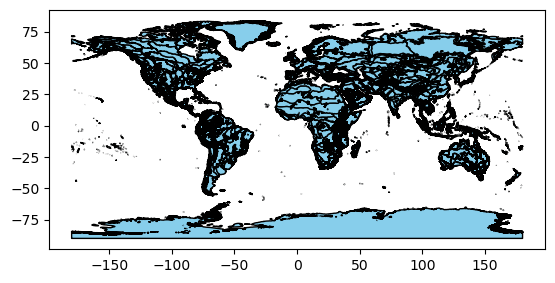

In [44]:
# Open up the ecoregions boundaries
ecoregions_gdf = (
    gpd.read_file(ecoregions_path)
    .rename(columns={
        'ECO_NAME': 'name',
        'SHAPE_AREA': 'area'})
    [['name', 'area', 'geometry']]
)

# Name the index so it will match the other data later on
ecoregions_gdf.index.name = 'ecoregion'

# Plot the ecoregions to check download
ecoregions_gdf.plot(edgecolor='black', color='skyblue')

In [45]:
ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
1,Admiralty Islands lowland rain forests,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((117.33111 -7.53306, 117.30525 ..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((36.7375 -3.13, 36.7375 -3.1316..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((36.38 -8.96583, 36.38 -8.96667..."


##### Identify the ecoregion for each observation

In [46]:
gbif_ecoregion_gdf = (
    ecoregions_gdf
    # Match the coordinate reference system of the GBIF data and the ecoregions
    # transform geometries to a new coordinate reference system
    .to_crs(gdf_monthly.crs)
    # Find ecoregion for each observation
    # spatial join
    .sjoin(
        gdf_monthly,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['month', 'name']]
)
gbif_ecoregion_gdf

,month,name
ecoregion,,
12,6,Alberta-British Columbia foothills forests
12,6,Alberta-British Columbia foothills forests
12,6,Alberta-British Columbia foothills forests
12,6,Alberta-British Columbia foothills forests
12,6,Alberta-British Columbia foothills forests
...,...,...
833,6,Northern Rockies conifer forests
833,6,Northern Rockies conifer forests
833,6,Northern Rockies conifer forests


##### Count the observations in each ecoregion each month

In [47]:
def get_monthly_regional_observations(df, region_type, occurrence_name):

    occurrence_df = (
        df
        # For each region, for each month...
        .groupby([region_type, 'month'])
        # count the number of occurrences
        .agg(occurrences=(occurrence_name, 'count'))
    )

    # Get rid of rare observations (possible misidentification)
    occurrence_df = occurrence_df[occurrence_df["occurrences"] > 1]

    # Take the mean by region
    mean_occurrences_by_region = (
        occurrence_df
        .groupby([region_type])
        .mean()
    )

    # Take the mean by month
    mean_occurrences_by_month = (
        occurrence_df
        .groupby(['month'])
        .mean()
    )

    # Normalize by space and time for sampling effort
    # This accounts for the number of active observers in each location and time of year
    occurrence_df['norm_occurrences'] = (
        occurrence_df
        / mean_occurrences_by_region
        / mean_occurrences_by_month
    )

    return occurrence_df

In [48]:
occurrence_df = get_monthly_regional_observations(gbif_ecoregion_gdf, 'ecoregion', 'name')

occurrence_df

occurrences  norm_occurrences
ecoregion month                               
12        5               12          0.001558
          6               46          0.003290
          7               10          0.001355
16        5              510          0.004681
          6              718          0.003631
...                      ...               ...
833       5              152          0.000802
          6             1649          0.004795
          7              746          0.004108
          8              220          0.002813
          9               21          0.000645

[537 rows x 2 columns]

##### Create a simplified GeoDataFrame for plot

In [49]:
"""
Streamlining plotting with hvplot by simplifying the geometry, projecting it to a Mercator projection that is compatible with
geoviews, and cropping off areas in the Arctic.
"""

# Speed up processing
ecoregions_gdf.geometry = ecoregions_gdf.simplify(
    .1, preserve_topology=False)

# Change the CRS to Mercator for mapping
ecoregions_gdf = ecoregions_gdf.to_crs(ccrs.Mercator())

ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,MULTIPOLYGON EMPTY
1,Admiralty Islands lowland rain forests,0.170599,"POLYGON ((16411777.375 -229101.376, 16384825.7..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((3391149.749 4336064.109, 33846..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((7369001.698 4093509.259, 73168..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-17930832.005 8046779.358, -17..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((14113374.546 501721.962, 14128..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((4298787.669 -137583.786, 42727..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((4267432.68 -493759.165, 428533..."


##### Mapping monthly migration

In [50]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = ecoregions_gdf.join(occurrence_df)

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds

# Define the slider widget
slider = pn.widgets.DiscreteSlider(
    name='month', 
    options={calendar.month_name[i]: i for i in range(1, 13)}
)

# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        colorbar=False,
        widgets={'month': slider},
        widget_location='bottom',
        width=500,
        height=500
    )
)

# Save the plot
migration_plot.save('willow-flycatcher-migration.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'9419d824-35f3-43cc-9f36-d09550602703': {'version…

#### Migration

The plot demonstrates changes in Willow Flycatcher distribution as the result of migration patterns across a single year (2023). Timing in migration reflects the annual cycles of breeding and wintering. Typically this species will journey between [2,000 to over 5,000 miles per year](https://doi.org/10.2737/RMRS-GTR-60) in keeping with these cycles. [Dates of migration]((https://doi.org/10.2737/RMRS-GTR-60)) (arrival and departure) vary depending on the latitude. In the early 1990s, spring arrivals were indicated to be near 30-35° North around late April and early May. At 46-50° North, the spring arrival window was between late May and mid-June. Fall departure dates were around late August and early October at 30-35° North whereas in the 46-50° North range the dates were between late August and late September. 

The northern limit of the species distribution and as a consequence, migration dates, are likely to move in response to climate change. Between the late 1960s and early 2000s, the northern hemisphere spring maximum temperatures increased about 1°C and during that period a [mean shift north in breeding range](https://doi.org/10.1111/j.1523-1739.2006.00609.x) for the Willow Flycatcher was observed (135.44 ± 59.37 km). Moreover, global temperatures are continuing to increase; 2023 was approximately [1.36°C warmer](https://climate.nasa.gov/vital-signs/global-temperature) than the preindustrial average (1850-1900). The 2023 migration plot illustrates a latitude realignment compared to the early 2000s in the distribution corresponding to temperature signals. Spring arrivals in April approached 45° North and fall departures in the 46-50° North range were closer to October. Within the breeding range, there were no observations for April 2023 in Canada. The earliest spring arrivals appeared in May with the greatest in Ontario about 6 degrees north of the 1990s latitude. Between 46 and 50 degrees north latitude, few observations were recorded during May at 46° North (Quebec) compared to the largest occurrences near the top of the range at 49° North (British Columbia). In the United States, April arrivals were more prominent at 37° North in Illinois. Throughout May the lowest observations were recorded in the 30-35° North range (Arizona) and the highest occurrences surpassed that range at 39° North (Pennsylvania). The flycatcher distribution is strongly correlated with temperature and as evidenced by these observations, is likely expanding its northern limit and migration timing in response to climate change. 

#### References

Afzal, P. (2024, January 4). *Endangered Willow Flycatchers in San Diego are adapting to climate change.* Cornell Lab of Ornithology. https://www.allaboutbirds.org/news/endangered-willow-flycatchers-in-san-diego-are-adapting-to-climate-change 

Bird Genoscape Project. (n.d.). *Willow Flycatcher.* https://www.birdgenoscape.org/willow-flycatcher 

Chamberlain, S. (2024). *pygbif* (Version 0.6.4) [Computer software]. GitHub. https://github.com/gbif/pygbif/releases/tag/v0.6.4

Cornell Lab of Ornithology. (n.d.). *Willow Flycatcher life history.* All About Birds. https://www.allaboutbirds.org/guide/Willow_Flycatcher/lifehistory

Dinerstein, E., Olson, D., Joshi, A., Vynne, C., Burgess, N. D., Wikramanayake, E., … Saleem, M. (2017). An ecoregion-based approach to protecting half the terrestrial realm. *BioScience, 67*(6), 534–545. https://doi.org/10.1093/biosci/bix014

Finch, D. M. & Stoleson, S. H. (2000). Status, ecology, and conservation of the southwestern willow flycatcher. U.S. Department of Agriculture, Forest Service, Rocky Mountain Research Station. https://doi.org/10.2737/RMRS-GTR-60

Hitch, A. & Leberg, P. (2007). Breeding distributions of North American bird species moving north as a result of climate change. *Conservation Biology, 21*(2), 534-539. https://doi.org/10.1111/j.1523-1739.2006.00609.x

Jordahl, K., Van den Bossche, J., Fleischmann, M., Wasserman, J., McBride, J., Gerard, J., … Leblanc, F. (2024). *geopandas/geopandas: v1.0.1* (Version 1.0.1) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.12625316 

Met Office. (2024). *Cartopy: a cartographic python library with a Matplotlib interface* (Version 0.24.1) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13905945

NASA. (n.d.). *Global temperature*. https://climate.nasa.gov/vital-signs/global-temperature

National Audubon Society. (n.d.). *Willow Flycatcher.* Audubon. https://www.audubon.org/field-guide/bird/willow-flycatcher

Python Software Foundation. (2024). *Python* (Version 3.12.6) [Computer software]. https://docs.python.org/release/3.12.6 

Rudiger, P., Hansen, S. H., Bednar, J. A., Steven, J., Liquet, M., Little, B., … Bampton, J. (2024). *holoviz/geoviews: Version 1.13.0* (Version 1.13.0) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13782761

Rudiger, P., Liquet, M., Signell, J., Hansen, S. H., Bednar, J. A., Madsen, M. S., … Hilton, T. W. (2024). *holoviz/hvplot: Version 0.11.0* (Version 0.11.0) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13851295 

Rudiger, P., Hansen, S. H.,  Madsen, M. S., & Wu, J. (2024). *holoviz/panel: Version 1.5.2* (Version 1.5.2) [Computer software]. GitHub. https://github.com/holoviz/panel/releases/tag/v1.5.2

Tahoe National Forest. (n.d.). *Willow Flycatcher - introduction.* U.S. Forest Service. https://www.fs.usda.gov/detail/tahoe/landmanagement/resourcemanagement/?cid=stelprdb5357314#:~:text=The%20scientific%20name%20for%20willow,t 

The pandas development team. (2024). *pandas-dev/pandas: Pandas* (Version 2.2.2) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.3509134